In [1]:
import pandas as pd
import numpy as np
import datetime 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

pd.set_option('display.max_columns', 100)

In [2]:
# raw data is taken from Stocker package which uses Quandl API
agg_df = pd.read_csv('./agg_data2.csv', index_col=0)

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# narrowing data set to 2012 - 2017
# creating new column `year`
agg_df2 = (
    agg_df
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .query("year >= 2012")
    [['ticker', 'date', 'year', 'open', 'close']]
)

In [4]:
# getting the first day and last day of each year that is available in the data set
first_date_list = [agg_df2.query("year == '{}'".format(2012+i)).date.min() for i in range(6)]
last_date_list = [agg_df2.query("year == '{}'".format(2012+i)).date.max() for i in range(6)]
first_date_df =pd.DataFrame({"date": first_date_list}) 
last_date_df = pd.DataFrame({"date": last_date_list})

In [5]:
# filtering first day data
agg_first_date_df = (
    agg_df2
    .merge(first_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x.date.str[:4]))
    .rename(columns={"open": "open_first_day", "close": "close_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day', 'close_first_day']]
)

# filtering last day data
agg_last_date_df = (
    agg_df2
    .merge(last_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x.date.str[:4]))
    .rename(columns={"open": "open_last_day", "close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_last_day', 'close_last_day']]
)

# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='left')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("ticker")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='left')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['ticker', 'gains_pctg']]
    .groupby("ticker")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "variance"})
)

agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='ticker', how='inner')
)

In [6]:
agg_df3.head(3)

,ticker,avg_yearly_returns,variance
0,A,0.133075,0.068609
1,AAN,0.084080,0.057674
2,AAON,0.126208,0.089675


In [7]:
agg_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1651 entries, 0 to 1650
Data columns (total 3 columns):
ticker                1651 non-null object
avg_yearly_returns    1651 non-null float64
variance              1651 non-null float64
dtypes: float64(2), object(1)
memory usage: 51.6+ KB


In [8]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [9]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

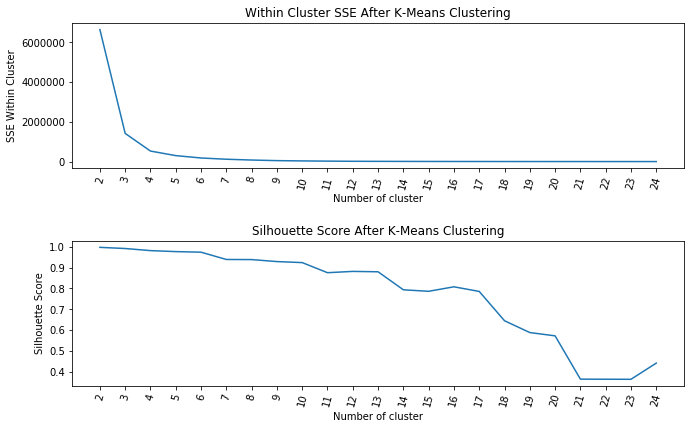

In [10]:
plot_cluster(agg_df3, max_loop=25)

1. From the first graph, `Within Cluster SSE After K-Means Clustering`, we can see that as the number of clusters increase pass 4, the sum of square of errors within clusters plateaus off. 

2. As for the second graph, `Silhouette Score After K-Means Clustering`, we can see that there are various parts of the graph where a kink can be seen. 

In [115]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [116]:
first_trial = apply_cluster(agg_df3, clusters=17)

clustering performance
-----------------------------------
silhouette score: 0.79
sse withing cluster: 4925.0


In [14]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,0,0.128180,0.105072,1506
1,15,0.399462,1.055879,80
2,10,0.665059,3.106788,28
3,14,1.003335,5.965267,15
4,6,1.212379,9.210504,6
5,8,1.638056,17.217217,3
6,16,1.811096,22.714211,1
7,13,2.150359,29.579875,3
8,11,2.248405,40.914102,1
9,12,2.853394,51.105084,1


From 

In [15]:
agg_df3_sub = agg_df3.query("cluster == 0").reset_index(drop=True)

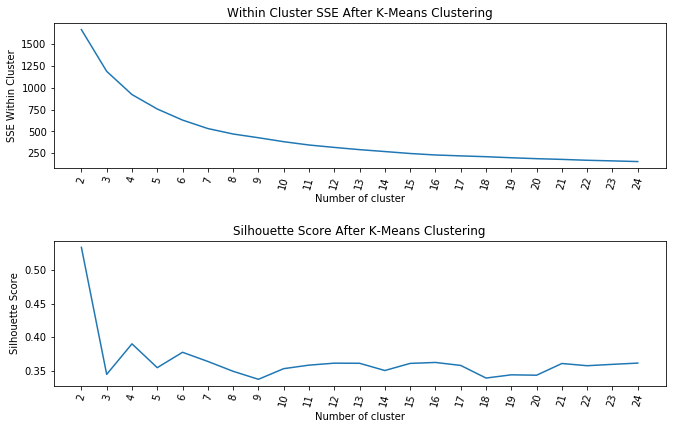

In [16]:
plot_cluster(agg_df3_sub, max_loop=25)

In [117]:
second_trial= apply_cluster(agg_df3_sub, clusters=6)

clustering performance
-----------------------------------
silhouette score: 0.38
sse withing cluster: 630.0


In [19]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,0,-0.070141,0.095642,184
1,3,0.074051,0.364641,87
2,4,0.101346,0.043300,638
3,5,0.123799,0.168898,190
4,2,0.246546,0.076607,331
5,1,0.391000,0.313726,76


In [71]:
second_trial.head(3)

,ticker,avg_yearly_returns,variance,cluster
0,A,0.133075,0.068609,4
1,AAN,0.084080,0.057674,4
2,AAON,0.126208,0.089675,4


In [118]:
def get_sharpe_ratio_df(df):
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [119]:
second_trial_w_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [124]:
def get_transform_df(df_w_sharpe_ratio):
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['variance', 'cluster']]
        .pipe(lambda x: x.assign(type='variance'))
        .rename(columns={"variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [111]:
sub_cluster_transform, sub_cluster_sharpe_ratio = get_transform_df(second_trial_w_sharpe_ratio)

In [130]:
def cluster_perf(transform_df, sharpe_ratio_df):
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

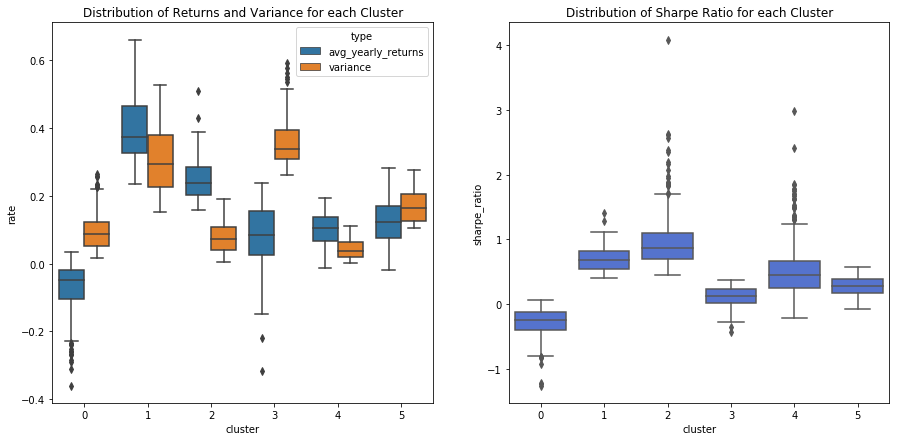

In [131]:
cluster_perf(sub_cluster_transform, sub_cluster_sharpe_ratio)

In [114]:
best_sub_cluster = second_trial.query("cluster == 2")

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


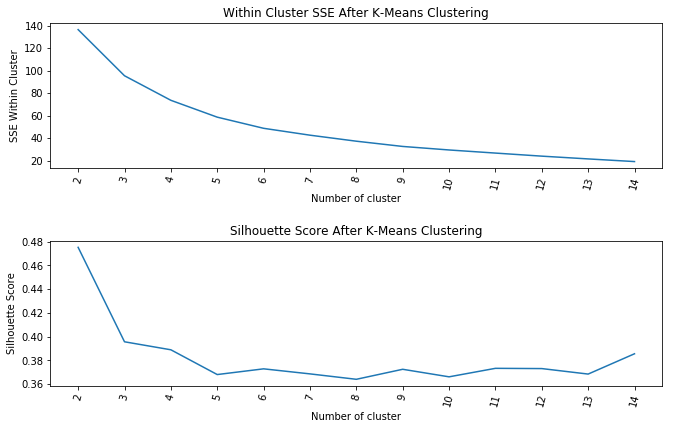

In [43]:
plot_cluster(best_sub_cluster, max_loop=15)

In [120]:
third_trial = apply_cluster(best_sub_cluster, clusters=4)

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


clustering performance
-----------------------------------
silhouette score: 0.39
sse withing cluster: 74.0


C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [67]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,variance,ticker
0,3,0.199555,0.085915,102
1,0,0.227018,0.034496,111
2,1,0.303590,0.137955,71
3,2,0.308470,0.063184,47


In [121]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)

In [126]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)

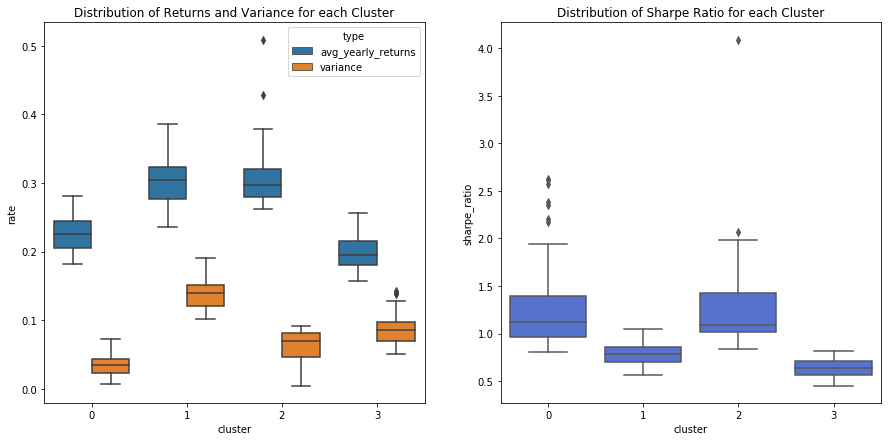

In [132]:
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

In [46]:
us_yield_curve_5years_dict = {"year": [2012, 2013, 2014, 2015, 2016, 2017],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

In [76]:
avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)